In [1]:
import numpy as np
import pandas as pd
from scipy import spatial
# import volpriceinference a vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Load the data

In [28]:
with pd.HDFStore('../data/spy_daily_estimates_2003-2017_1000_1sec.hdf') as store:
    daily_rtn = store['daily_rtn'] * 252
    vol = store['discrete_vol_est'] * 252**2 
    
    data = pd.concat([daily_rtn, vol.diffusion + vol.jumps], axis=1).dropna()
    data.columns = ['rtn', 'vol']

In [29]:
data.head()

,rtn,vol
2003-01-02,6.419615,8.799756
2003-01-03,0.539956,7.785992
2003-01-06,5.150512,4.586335
2003-01-07,-0.896750,8.294531
2003-01-08,-2.748119,6.446751


In [30]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,rtn,vol
rtn,5.523276,-0.229847
vol,-0.229847,1.886587


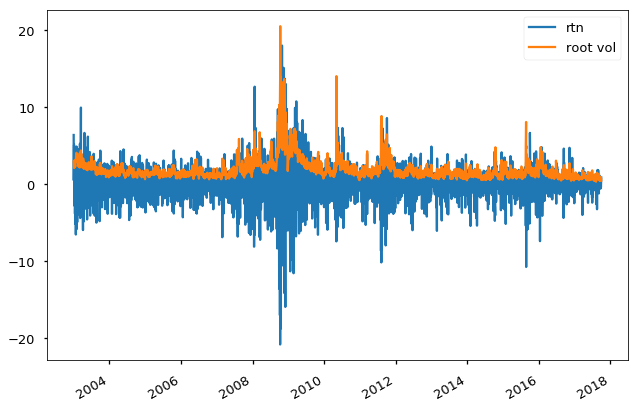

In [31]:
fig1, ax1 = mpl.pyplot.subplots()
data['rtn'].plot(ax=ax1)
data['vol'].apply(np.sqrt).plot(ax=ax1, label='root vol')
ax1.legend()

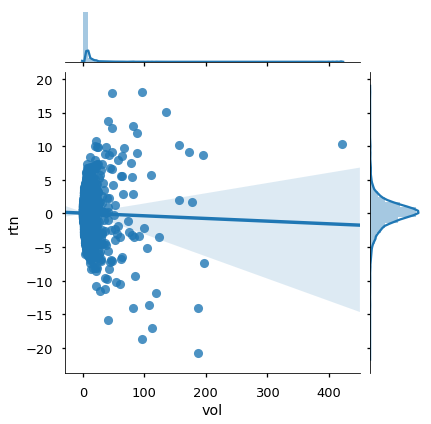

In [32]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [33]:
vl.estimate_params(data)

({'gamma': 0.25965685942691796,
  'beta': 0.1113552770767416,
  'psi': -0.15373902507632284,
  'zeta': 0.9086856628806307,
  'delta': 0.150959737857387,
  'rho': 0.7409166751231047,
  'scale': 9.634818429058537},
            beta     delta     gamma       psi       rho      scale      zeta
 beta   0.000097  0.000000 -0.000035 -0.000091  0.000000   0.000000  0.000000
 delta  0.000000  0.004890  0.000000  0.000000 -0.009422  -0.018271  0.000000
 gamma -0.000035  0.000000  0.000648 -0.000080  0.000000   0.000000  0.000000
 psi   -0.000091  0.000000 -0.000080  0.000149  0.000000   0.000000  0.000000
 rho    0.000000 -0.009422  0.000000  0.000000  0.026807  -0.270664  0.000000
 scale  0.000000 -0.018271  0.000000  0.000000 -0.270664  11.296510  0.000000
 zeta   0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000431)

In [34]:
omega, omega_cov = vl.estimate_params_strong_id(data)

In [35]:
omega

{'gamma': 0.25965685942691796,
 'beta': 0.1113552770767416,
 'psi': -0.15373902507632284,
 'zeta': 0.9086856628806307,
 'delta': 0.150959737857387,
 'rho': 0.7409166751231047,
 'scale': 9.634818429058537,
 'phi': -0.3060995340244961,
 'pi': -0.12981873557701273,
 'theta': 0.5817576559095872}

In [40]:
data.vol.sort_values(ascending=True).head()

2017-08-07    0.123335
2017-09-14    0.214673
2017-09-22    0.216867
2016-11-25    0.226227
2017-07-24    0.242692
Name: vol, dtype: float64

In [ ]:
qlr_stats = vl.compute_qlr_stats(omega=omega, omega_cov=omega_cov, equity_dim=10, vol_dim=10, vol_min=-3,
                                 vol_max=0, equity_min=0, equity_max=2, use_tqdm=True, case=1)


In [ ]:
qlr_draws = vl.compute_qlr_sim(omega=omega, omega_cov=omega_cov, vol_dim=10, equity_dim=10, equity_max=3,
                                vol_min=-3, innov_dim=200, alpha=2.5)

In [ ]:
qlr_draws.to_json('../results/qlr_draws_on_data.tmp.json')

In [ ]:
accepted_vals = (qlr_stats < qlr_draws).stack().reset_index().rename(columns={0:'value'}).query(
    'value').drop('value', axis='columns')

In [ ]:
def constraint(scale, psi, zeta, equity_price):
    
    vol_price  = -1 / scale - ((psi * (equity_price-1) + zeta/2 * (equity_price-1)**2))
    
    return  vol_price

In [ ]:
fig3, ax3 = mpl.pyplot.subplots()
ax3.scatter(y=accepted_vals.equity, x=accepted_vals.vol, marker='o', s=60, label='Confidence Region')
ax3.set_xlim([-3.5, .5])
ax3.set_ylim([-.5, 3.5])
yvals = np.linspace(0,5,100)
xvals = [constraint(omega['scale'], omega['psi'], omega['zeta'], x) for x in yvals]
ax3.plot(xvals, yvals, color='orange', label='Constraint')
ax3.axvline(0,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axvline(-15,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axhline(0,  xmin=.5 /16, xmax=1 - .5/16, color='black')
ax3.axhline(5,  xmin=.5 /16, xmax=1 - .5/16, color='black')
ax3.legend()
ax3.set_ylabel('Equity Price')
ax3.set_xlabel('Volatility Price')
fig3.savefig('../doc/figures/confidence_region.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

In [ ]:
accepted_vals.min()

In [ ]:
accepted_vals.max()